In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *

plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'viridis'})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_6_ss6/')

In [ ]:
errors = compute_errors(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

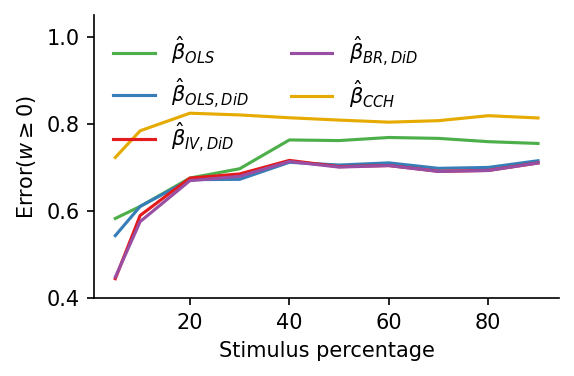

In [22]:
plot_errors(errors, 'n_stim', 
            keys=['beta_ols', 
                  'beta_ols_did', 
                  'beta_iv_did', 
                  'beta_brew_did', 
                  'naive_cch'], 
            legend_kws=dict(ncol=2),
            ylim=[0.4,1.05],
            save='sweep_6_error_stim_percentage', xlabel='Stimulus percentage')

Text(0.5, 0, 'Stimulus percentage')

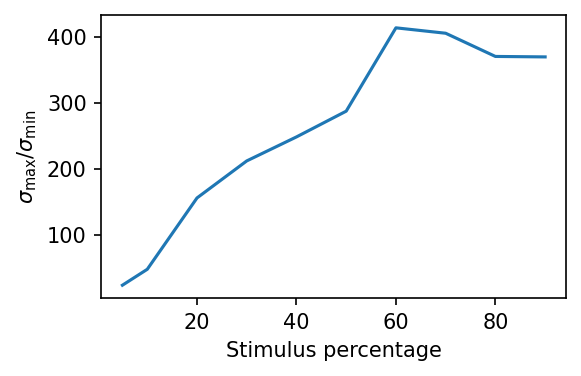

In [23]:
ata_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'], axis=1)
plt.figure()
sns.lineplot(
    data=ata_df,
    x="n_stim", y='cov_condition'
)
plt.ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
plt.xlabel('Stimulus percentage')

In [24]:
# data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'], axis=1)
data_df = compute_condition(data_path, lag=1)

  0%|          | 0/10 [00:00<?, ?it/s]

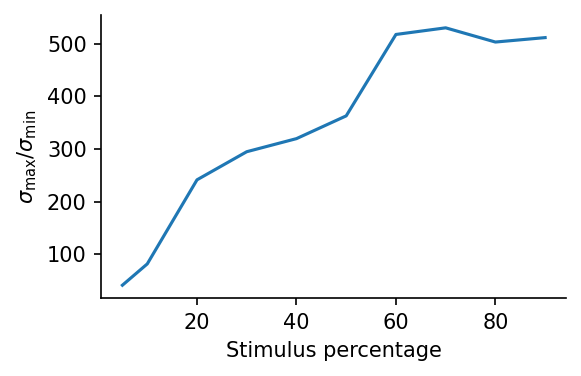

In [25]:
plt.figure()
sns.lineplot(
    data=data_df,
    x="n_stim", y='cov_condition'
)
plt.ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
plt.xlabel('Stimulus percentage')
# plt.ylim(0.5, 0.9)
# plt.margins(0.1)
sns.despine()
savefig(f'sweep_6_condition_n_stim')

# Regression

In [ ]:
samples = compute_all_samples(data_path)

In [26]:
concsamples = pd.concat([v for v in samples.values()])

In [27]:
concsamples['ww'] = concsamples['weight'].round(4)
concsamples = concsamples.groupby('ww').sample(1)

In [28]:
concsamples = concsamples.groupby('n_stim').sample(100)

<AxesSubplot:ylabel='Density'>

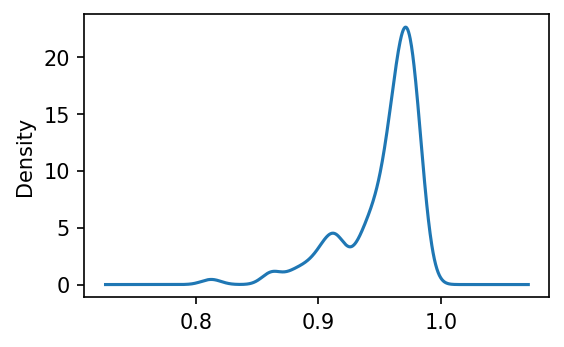

In [29]:
concsamples.hit_rate.plot.density()

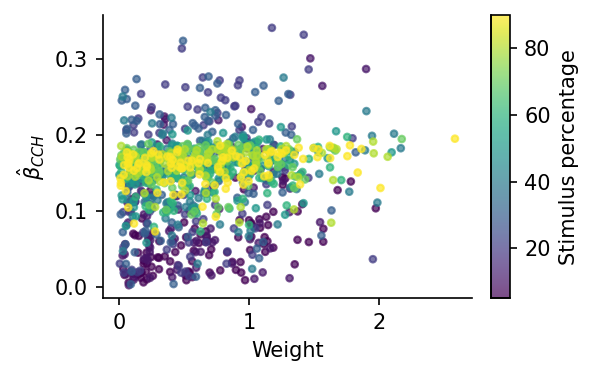

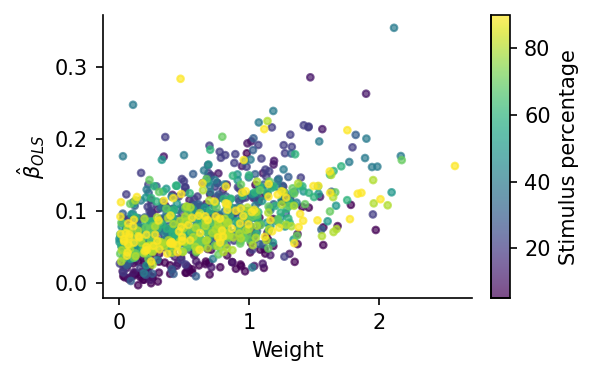

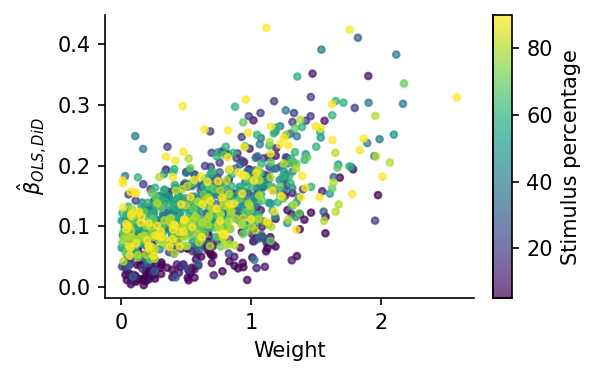

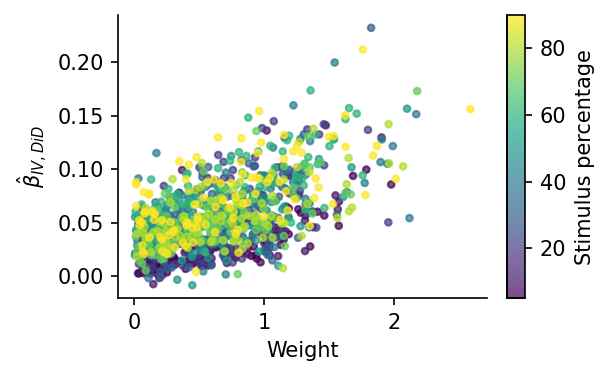

In [30]:
# concsamples = concsamples.sample(frac=1)
for key in ['naive_cch', 'beta_ols', 'beta_ols_did', 'beta_iv_did']:
#     plt.figure()
#     sns.scatterplot(data=concsamples, x='weight', y=key, c=concsamples['n_stim'], alpha=.7)
#     sns.despine()
    
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    sc = ax.scatter(
        concsamples['weight'],
        concsamples[key],
        c=concsamples['n_stim'],
        s=10,
        alpha=0.7
    )
    lab = ",".join([labels[v] for v in key.split("_")[1:]])
    ax.set_xlabel('Weight')
    ax.set_ylabel(fr'$\hat{{\beta}}_{{{lab}}}$')
    cbar = plt.colorbar(sc, cax=cax)
    cbar.ax.set_ylabel('Stimulus percentage')
    sns.despine()
    savefig(f'sweep_6_scatter_{key}')

# Classification

In [31]:
keys = ['beta_ols', 'beta_ols_did', 'beta_iv_did', 'naive_cch', 'beta_brew_did']

In [32]:
auroc = []
label = lambda x: ','.join([labels[l] for l in x.split('_')[1:]])
for index, df in samples.items():
#     df = rectify_keys(df, keys)
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key)
        score = {
            'n_stim': ser.n_stim,
            'group': label(key),
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

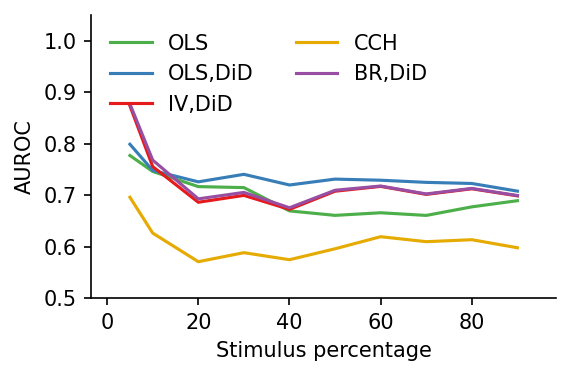

In [33]:
plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="n_stim", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('Stimulus percentage')
plt.ylim(0.5, 1.05)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=2)
savefig(f'sweep_6_auroc_n_stim')

# Convergence

In [34]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [35]:
index = int(errors[list(errors.keys())[0]].query('n_stim==90').index.values)
df = samples[index]

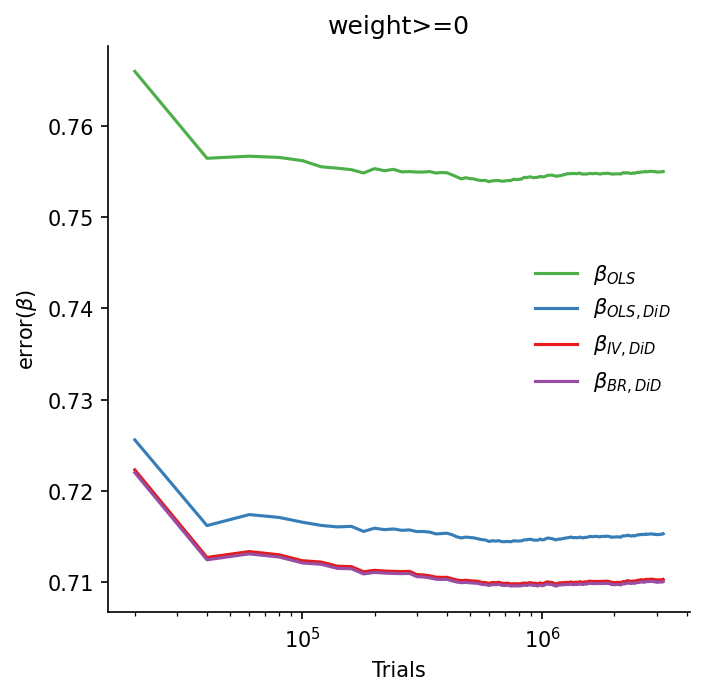

In [36]:
plot_error_convergence(error_convergence, index, keys=['beta_ols', 'beta_ols_did', 'beta_iv_did', 'beta_brew_did'])

In [ ]:
error_convergence_trials = compute_error_convergence_trials(data_path)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey='row', figsize=(4,1.5), dpi=150)
for i, (sparsity, df) in enumerate(errors[list(errors.keys())[0]].query('n_stim in [5,30,90]').groupby('n_stim')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_iv_did', 'error_beta_brew_did', 'error_beta_ols_did'], 
        axs=[axs[i]], legend=i==4, xlabels=(True,True), ylabels=[i==0]*2)
    axs[i].set_title(f'{sparsity:.1f}')
savefig('sweep_6_stim_percentage_convergence')

# Error difference

In [ ]:
error_trials = compute_error_trials(data_path)

In [ ]:
errors = compute_error_confidence(errors, error_trials)

In [ ]:
errors[list(errors.keys())[0]][['n_stim', 'error_ols_iv_did_pval', 'error_ols_iv_did_statistic']]

In [ ]:
plot_error_difference(errors, 'n_stim')